#### Load Python Libraries

In [50]:
##load libraries 
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
% matplotlib inline

In [51]:
#path to train and test files
train_path = "train_lofi_rowid_Nov13.csv"
trainDF = pd.read_csv(train_path)
final_test_path = "test_lofi_rowid_Nov13.csv"
#testDF = pd.read_csv(final_test_path)

### Check the data
Data set has GR and labels for 4000 wells. There are 4 main columns in the data frame:
* row_id: Each well has 1100 rows and a random number of log facies. The row_id column represents depth in the well.
* well_id: each well has a unique ID
* GR: Gamma Ray or GAMMA log and it is noisy. 
* label: label is the log facies label and it can hold values from 0 to 4.  0: no label, 1: symmetrical, 2: cylindrical, 3: funnel, and 4: bell

Test set does not contain the label column and we need to calculate and submit it for the competition.

In [52]:
print(trainDF.shape)
trainDF.head()

(4400000, 4)


,row_id,well_id,GR,label
0,0,0,99.005617,0
1,1,0,105.563944,0
2,2,0,105.921065,0
3,3,0,113.513354,0
4,4,0,101.523783,0


0    2326115
1     521372
4     519394
2     518039
3     515080
Name: label, dtype: int64


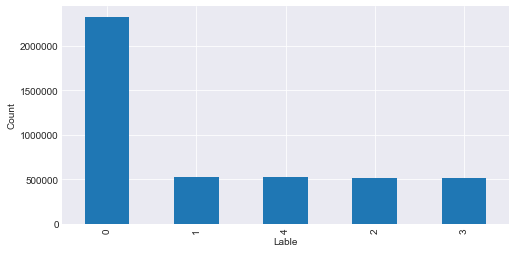

In [4]:
##Visualizing label distribution
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
trainDF["label"].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('Lable')
print(trainDF["label"].value_counts())

In [5]:
trainDF.describe()

,row_id,well_id,GR,label
count,4.400000e+06,4.400000e+06,4.400000e+06,4.400000e+06
mean,5.495000e+02,1.999500e+03,9.759792e+01,1.177333e+00
std,3.175426e+02,1.154701e+03,3.206393e+01,1.464788e+00
min,0.000000e+00,0.000000e+00,1.947262e+01,0.000000e+00
25%,2.747500e+02,9.997500e+02,6.569258e+01,0.000000e+00
50%,5.495000e+02,1.999500e+03,1.075080e+02,0.000000e+00
75%,8.242500e+02,2.999250e+03,1.235464e+02,2.000000e+00
max,1.099000e+03,3.999000e+03,1.618695e+02,4.000000e+00


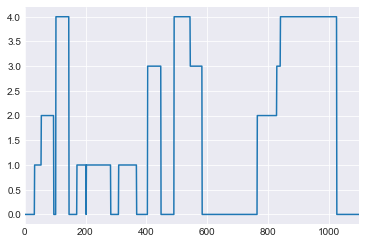

In [6]:
trainDF[trainDF.well_id==0].label.plot()

In [31]:
len(trainDF)

4400000

In [32]:
trainDF.head()

,row_id,well_id,GR,label
0,0,0,99.005617,0
1,1,0,105.563944,0
2,2,0,105.921065,0
3,3,0,113.513354,0
4,4,0,101.523783,0


In [33]:
trainDF.tail()

,row_id,well_id,GR,label
4399995,1095,3999,123.022784,0
4399996,1096,3999,117.469155,0
4399997,1097,3999,118.927403,0
4399998,1098,3999,127.449713,0
4399999,1099,3999,126.537612,0


### Feature engineering
By adding N (featureWinLen=5) of the GR values from before/after the current row as our extra features we can build better classifier

In [48]:
##Feature engineering. Using previous/next 5 signal values as input along with the main GR value
## This is not very correct as it will use signal values from other wells to fill the first 5 and last 5 signals - you can fix it in your own version :)
featureWinLen = 50
for ii in range(1,featureWinLen+1):
    trainDF["GR"+str(+ii)] = trainDF["GR"].shift(ii)
    trainDF["GR"+str(+ii)].fillna(trainDF.GR, inplace=True)
    trainDF["GR"+str(-ii)] = trainDF["GR"].shift(-ii)
    trainDF["GR"+str(-ii)].fillna(trainDF.GR, inplace=True)
display(trainDF.head())
display(trainDF.tail())

,row_id,well_id,GR,label,index,GR1,GR-1,GR2,GR-2,GR3,...,GR46,GR-46,GR47,GR-47,GR48,GR-48,GR49,GR-49,GR50,GR-50
0,0,0,99.005617,0,0,99.005617,105.563944,99.005617,105.921065,99.005617,...,99.005617,41.336780,99.005617,44.999495,99.005617,52.140537,99.005617,37.151558,99.005617,47.096457
1,1,0,105.563944,0,0,99.005617,105.921065,105.563944,113.513354,105.563944,...,105.563944,44.999495,105.563944,52.140537,105.563944,37.151558,105.563944,47.096457,105.563944,50.925787
2,2,0,105.921065,0,0,105.563944,113.513354,99.005617,101.523783,105.921065,...,105.921065,52.140537,105.921065,37.151558,105.921065,47.096457,105.921065,50.925787,105.921065,46.637029
3,3,0,113.513354,0,0,105.921065,101.523783,105.563944,94.464482,99.005617,...,113.513354,37.151558,113.513354,47.096457,113.513354,50.925787,113.513354,46.637029,113.513354,40.885697
4,4,0,101.523783,0,0,113.513354,94.464482,105.921065,103.864994,105.563944,...,101.523783,47.096457,101.523783,50.925787,101.523783,46.637029,101.523783,40.885697,101.523783,41.443098


,row_id,well_id,GR,label,index,GR1,GR-1,GR2,GR-2,GR3,...,GR46,GR-46,GR47,GR-47,GR48,GR-48,GR49,GR-49,GR50,GR-50
4395595,1095,3995,120.149593,0,0,122.133377,121.556969,111.711869,114.023981,116.874372,...,117.289851,120.149593,121.902452,120.149593,115.421041,120.149593,125.441494,120.149593,121.075892,120.149593
4395596,1096,3995,121.556969,0,0,120.149593,114.023981,122.133377,112.995564,111.711869,...,114.511331,121.556969,117.289851,121.556969,121.902452,121.556969,115.421041,121.556969,125.441494,121.556969
4395597,1097,3995,114.023981,0,0,121.556969,112.995564,120.149593,119.890067,122.133377,...,109.344210,114.023981,114.511331,114.023981,117.289851,114.023981,121.902452,114.023981,115.421041,114.023981
4395598,1098,3995,112.995564,0,0,114.023981,119.890067,121.556969,112.995564,120.149593,...,111.851988,112.995564,109.344210,112.995564,114.511331,112.995564,117.289851,112.995564,121.902452,112.995564
4395599,1099,3995,119.890067,0,0,112.995564,119.890067,114.023981,119.890067,121.556969,...,117.143631,119.890067,111.851988,119.890067,109.344210,119.890067,114.511331,119.890067,117.289851,119.890067


In [34]:
import gc
from sklearn.model_selection import train_test_split

X_train, X_valid = train_test_split(trainDF, test_size=0.1, random_state=1118)

del trainDF
gc.collect()

X_train, X_test = train_test_split(X_train, test_size=0.5, random_state=1118)

# 
#X_train, X_train_del = train_test_split(X_train, test_size=0.5, random_state=1118)

#del X_train_del
#gc.collect()
print(len(X_train), len(X_valid), len(X_test))

1980000 440000 1980000


In [66]:
print(X_train.columns.tolist())

['row_id', 'well_id', 'GR', 'label', 'GR1', 'GR-1', 'GR2', 'GR-2', 'GR3', 'GR-3', 'GR4', 'GR-4', 'GR5', 'GR-5', 'GR6', 'GR-6', 'GR7', 'GR-7', 'GR8', 'GR-8', 'GR9', 'GR-9', 'GR10', 'GR-10', 'GR11', 'GR-11', 'GR12', 'GR-12', 'GR13', 'GR-13', 'GR14', 'GR-14', 'GR15', 'GR-15', 'GR16', 'GR-16', 'GR17', 'GR-17', 'GR18', 'GR-18', 'GR19', 'GR-19', 'GR20', 'GR-20', 'GR21', 'GR-21', 'GR22', 'GR-22', 'GR23', 'GR-23', 'GR24', 'GR-24', 'GR25', 'GR-25', 'GR26', 'GR-26', 'GR27', 'GR-27', 'GR28', 'GR-28', 'GR29', 'GR-29', 'GR30', 'GR-30', 'GR31', 'GR-31', 'GR32', 'GR-32', 'GR33', 'GR-33', 'GR34', 'GR-34', 'GR35', 'GR-35', 'GR36', 'GR-36', 'GR37', 'GR-37', 'GR38', 'GR-38', 'GR39', 'GR-39', 'GR40', 'GR-40', 'GR41', 'GR-41', 'GR42', 'GR-42', 'GR43', 'GR-43', 'GR44', 'GR-44', 'GR45', 'GR-45', 'GR46', 'GR-46', 'GR47', 'GR-47', 'GR48', 'GR-48', 'GR49', 'GR-49', 'GR50', 'GR-50']


In [67]:
features = X_train.columns.tolist()
features.remove('well_id')
features.remove('label')

In [ ]:
print('training data processed')

params = {"objective": 'multi:softmax', 
          'num_class': 5,
          "booster": "gbtree",
          "eta": 0.3,
          "max_depth": 20,
          "subsample": 0.7,
          "silent": 1,
          'nthread': 4,
          'scale_pos_weight' : 1,
          "seed": 18}

num_boost_round = 100

print("Train a XGBoost model")

dtrain = xgb.DMatrix(X_train[features], X_train['label'])
dvalid = xgb.DMatrix(X_valid[features], X_valid['label'])

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

gbm40 = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
                early_stopping_rounds=2, verbose_eval=True)

training data processed
Train a XGBoost model
[0]	train-merror:0.035052	eval-merror:0.060005
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 2 rounds.
[1]	train-merror:0.022926	eval-merror:0.047965
[2]	train-merror:0.018462	eval-merror:0.043753
[3]	train-merror:0.015809	eval-merror:0.041313
[4]	train-merror:0.013765	eval-merror:0.039513
[5]	train-merror:0.012056	eval-merror:0.038389
[6]	train-merror:0.010688	eval-merror:0.037283
[7]	train-merror:0.009359	eval-merror:0.036301
[8]	train-merror:0.008198	eval-merror:0.035508
[9]	train-merror:0.007124	eval-merror:0.034821
[10]	train-merror:0.006194	eval-merror:0.034237
[11]	train-merror:0.005281	eval-merror:0.03379
[12]	train-merror:0.004517	eval-merror:0.033341
[13]	train-merror:0.003891	eval-merror:0.032914
[14]	train-merror:0.003278	eval-merror:0.03254
[15]	train-merror:0.002741	eval-merror:0.032235
[16]	train-merror:0.00223	eval-merror:0.031932
[17]	

### train

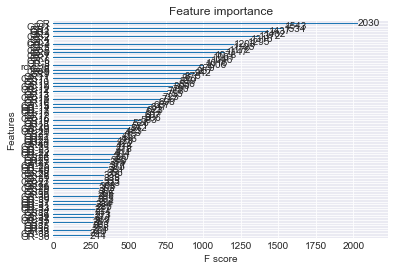

In [83]:
# 40
plot_importance(gbm40)

### train_test_result_predict

In [70]:
X_test_result = gbm.predict(xgb.DMatrix(X_test[features]))

In [66]:
X_test.head()

,row_id,well_id,GR,label,GR3,GR-3,GR4,GR-4,GR5,GR-5,GR6,GR-6,GR7,GR-7,GR8,GR-8,GR9,GR-9,GR10,GR-10
2723875,275,2476,133.540099,0,126.166850,130.757434,130.418613,127.391419,129.246431,136.182159,131.429061,128.381343,126.376379,116.628091,139.190000,113.722729,126.255954,103.238979,125.970557,90.775972
3431100,200,3119,87.523208,4,95.768095,74.269618,92.439070,85.485672,96.308130,78.021948,105.721800,90.051017,106.769255,90.028488,107.378683,84.285848,114.279463,70.973834,102.596789,82.512611
3980387,587,3618,61.992029,1,90.695657,42.270694,84.491728,47.362040,109.524767,49.390428,114.588477,45.484695,126.100684,52.250846,126.553585,50.585309,124.169425,52.443299,124.535789,50.408843
3634926,526,3304,137.649108,0,127.297793,134.931870,132.538662,131.254479,135.281116,131.470783,131.194329,127.457636,133.089696,130.338018,127.333504,131.887059,133.810380,131.033272,132.408005,132.543081
2189695,695,1990,60.338285,1,64.743755,57.471922,87.832329,59.005507,84.153176,49.502184,80.560520,49.351208,89.936069,42.911026,99.384531,48.830188,100.890174,48.122160,107.227097,49.263810


In [16]:
len(X_test)

440000

In [15]:
gbm40

In [17]:
X_test_result40 = gbm40.predict(xgb.DMatrix(X_test[features]))

In [18]:
##create some evaluation methods
def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)
    
    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(['accuracy', 'precision', 'recall', 'F1'])
    
    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(['macro precision', 'macro recall', 'macro F1'])
    
    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis = 1)
    cm_col_sums = cm.sum(axis = 0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis = 1)
    
    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0,0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(['average accuracy',
                          'micro-averaged precision/recall/F1'])
    
    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist; mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist; mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist;
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(['majority class accuracy', 'majority class recall',
                          'majority class precision', 'majority class F1'])
        
    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(['expected accuracy', 'kappa'])
    

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(['random guess accuracy', 'random guess precision',
                          'random guess recall', 'random guess F1'])
    
    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist**2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(['random weighted guess accuracy',
                          'random weighted guess precision',
                          'random weighted guess recall',
                          'random weighted guess F1'])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels
                  
    return output_df

In [14]:
##evaluate the performance
evaluation_result = Evaluate(actual = X_test['label'],
                                 predicted = X_test_result40,
                                 labels = [0, 1, 2, 3, 4])
display(evaluation_result)

Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[461865    699      0    952    912]
 [  1252  96724   2400   2592   1170]
 [     0   1592 100792    715    724]
 [  3356   3603   1408  93705    626]
 [  3142   1866   1260    578  98067]]


,0,1,2,3,4
accuracy,0.967219,0.967219,0.967219,0.967219,0.967219
precision,0.983497,0.925730,0.952125,0.950914,0.966187
recall,0.994481,0.928806,0.970806,0.912433,0.934746
F1,0.988959,0.927266,0.961375,0.931276,0.950206
macro precision,0.955691,0.955691,0.955691,0.955691,0.955691
macro recall,0.948254,0.948254,0.948254,0.948254,0.948254
macro F1,0.951816,0.951816,0.951816,0.951816,0.951816
average accuracy,0.986888,0.986888,0.986888,0.986888,0.986888
micro-averaged precision/recall/F1,0.967219,0.967219,0.967219,0.967219,0.967219
majority class accuracy,0.527759,0.000000,0.000000,0.000000,0.000000


In [69]:
print(featureWinLen)

10


In [33]:
testDF = pd.read_csv(final_test_path)

In [34]:
testDF

,row_id,well_id,GR
0,0,5000,134.943504
1,1,5000,127.004675
2,2,5000,133.159255
3,3,5000,134.411762
4,4,5000,135.748644
5,5,5000,124.695214
6,6,5000,141.253217
7,7,5000,137.763622
8,8,5000,131.665785
9,9,5000,140.515328


#### Prepare the test set for submision

In [22]:
##first step feature engieering
#featureWinLen is set from training phase
for ii in range(1,featureWinLen+1):
    testDF["GR"+str(ii)] = testDF["GR"].shift(ii)
    testDF["GR"+str(ii)].fillna(testDF.GR, inplace=True)
    testDF["GR"+str(-ii)] = testDF["GR"].shift(-ii)
    testDF["GR"+str(-ii)].fillna(testDF.GR, inplace=True)
display(testDF.head())
display(testDF.tail())

,row_id,well_id,GR,GR1,GR-1,GR2,GR-2,GR3,GR-3,GR4,...,GR46,GR-46,GR47,GR-47,GR48,GR-48,GR49,GR-49,GR50,GR-50
0,0,5000,134.943504,134.943504,127.004675,134.943504,133.159255,134.943504,134.411762,134.943504,...,134.943504,124.500675,134.943504,128.486149,134.943504,134.235342,134.943504,131.901307,134.943504,130.176440
1,1,5000,127.004675,134.943504,133.159255,127.004675,134.411762,127.004675,135.748644,127.004675,...,127.004675,128.486149,127.004675,134.235342,127.004675,131.901307,127.004675,130.176440,127.004675,122.313045
2,2,5000,133.159255,127.004675,134.411762,134.943504,135.748644,133.159255,124.695214,133.159255,...,133.159255,134.235342,133.159255,131.901307,133.159255,130.176440,133.159255,122.313045,133.159255,125.068529
3,3,5000,134.411762,133.159255,135.748644,127.004675,124.695214,134.943504,141.253217,134.411762,...,134.411762,131.901307,134.411762,130.176440,134.411762,122.313045,134.411762,125.068529,134.411762,128.467851
4,4,5000,135.748644,134.411762,124.695214,133.159255,141.253217,127.004675,137.763622,134.943504,...,135.748644,130.176440,135.748644,122.313045,135.748644,125.068529,135.748644,128.467851,135.748644,122.757957


,row_id,well_id,GR,GR1,GR-1,GR2,GR-2,GR3,GR-3,GR4,...,GR46,GR-46,GR47,GR-47,GR48,GR-48,GR49,GR-49,GR50,GR-50
384995,1095,5349,134.221769,127.480840,135.804491,125.349253,126.124399,120.417465,117.591583,131.035860,...,127.466824,134.221769,125.053597,134.221769,133.501000,134.221769,130.449292,134.221769,129.461615,134.221769
384996,1096,5349,135.804491,134.221769,126.124399,127.480840,117.591583,125.349253,132.555150,120.417465,...,130.176880,135.804491,127.466824,135.804491,125.053597,135.804491,133.501000,135.804491,130.449292,135.804491
384997,1097,5349,126.124399,135.804491,117.591583,134.221769,132.555150,127.480840,126.124399,125.349253,...,128.238882,126.124399,130.176880,126.124399,127.466824,126.124399,125.053597,126.124399,133.501000,126.124399
384998,1098,5349,117.591583,126.124399,132.555150,135.804491,117.591583,134.221769,117.591583,127.480840,...,121.900500,117.591583,128.238882,117.591583,130.176880,117.591583,127.466824,117.591583,125.053597,117.591583
384999,1099,5349,132.555150,117.591583,132.555150,126.124399,132.555150,135.804491,132.555150,134.221769,...,123.278347,132.555150,121.900500,132.555150,128.238882,132.555150,130.176880,132.555150,127.466824,132.555150


In [23]:
#run the classifier trained by our training data set on the public test set
test_result = gbm40.predict(xgb.DMatrix(testDF[features]))

#### Generate submission file
Please do not change the format(columns)/path and file name for final submission.
For leaderboard you only need to submit sumbission.csv file but for final submission you need to submit your final notebook.

In [24]:
testDF["PredictedLabel"] = test_result

In [25]:
len(test_result)

385000

In [26]:
len(testDF)

385000

In [27]:
testDF.head()

,row_id,well_id,GR,GR1,GR-1,GR2,GR-2,GR3,GR-3,GR4,...,GR-11,GR12,GR-12,GR13,GR-13,GR14,GR-14,GR15,GR-15,PredictedLabel
0,0,5000,134.943504,99.005617,127.004675,99.005617,133.159255,99.005617,134.411762,99.005617,...,123.697221,99.005617,125.037572,99.005617,139.320184,99.005617,123.521163,99.005617,129.253439,0.0
1,1,5000,127.004675,134.943504,133.159255,105.563944,134.411762,105.563944,135.748644,105.563944,...,125.037572,105.563944,139.320184,105.563944,123.521163,105.563944,129.253439,105.563944,130.861415,0.0
2,2,5000,133.159255,127.004675,134.411762,134.943504,135.748644,105.921065,124.695214,105.921065,...,139.320184,105.921065,123.521163,105.921065,129.253439,105.921065,130.861415,105.921065,131.942513,0.0
3,3,5000,134.411762,133.159255,135.748644,127.004675,124.695214,134.943504,141.253217,113.513354,...,123.521163,113.513354,129.253439,113.513354,130.861415,113.513354,131.942513,113.513354,134.871830,0.0
4,4,5000,135.748644,134.411762,124.695214,133.159255,141.253217,127.004675,137.763622,134.943504,...,129.253439,101.523783,130.861415,101.523783,131.942513,101.523783,134.871830,101.523783,121.410511,0.0


In [26]:
testDF[["row_id","well_id","PredictedLabel"]].to_csv("submission.csv", index=False)